In [8]:
import tensorflow as tf

def inspect_tfrecord(file_path):
    dataset = tf.data.TFRecordDataset(file_path)
    for i, record in enumerate(dataset.take(1)):
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        print(f"Example {i} features: {example.features.feature.keys()}")
        for key, feature in example.features.feature.items():
            kind = feature.WhichOneof('kind')
            print(f"  {key}: {kind}")

# Inspect the first file to understand its structure
inspect_tfrecord(tfrecord_files[0])


Example 0 features: KeysView({'image': bytes_list {
  value: "\010\004\022\016\022\003\010\340\001\022\003\010\340\001\022\002\010\003"\200\230\t\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\377\376\377\37

2025-03-05 19:34:27.164868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 6 TFRecord files


2025-03-16 11:09:52.049722: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-03-16 11:09:56.202291: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total samples: 1000
Label distribution:
  beagle: 2 samples (0.20%)
  pinscher miniature: 9 samples (0.90%)
  whippet: 3 samples (0.30%)
  cattledog australian: 5 samples (0.50%)
  newfoundland: 4 samples (0.40%)
  terrier russell: 9 samples (0.90%)
  hound blood: 9 samples (0.90%)
  pariah indian: 3 samples (0.30%)
  danish swedish farmdog: 9 samples (0.90%)
  pembroke: 7 samples (0.70%)
  eskimo: 6 samples (0.60%)
  doberman: 10 samples (1.00%)
  basenji: 5 samples (0.50%)
  spaniel irish: 6 samples (0.60%)
  havanese: 7 samples (0.70%)
  terrier patterdale: 4 samples (0.40%)
  corgi cardigan: 4 samples (0.40%)
  spitz indian: 2 samples (0.20%)
  bakharwal indian: 5 samples (0.50%)
  weimaraner: 5 samples (0.50%)
  terrier dandie: 3 samples (0.30%)
  maltese: 10 samples (1.00%)
  hound basset: 4 samples (0.40%)
  chow: 7 samples (0.70%)
  dane great: 12 samples (1.20%)
  brabancon: 8 samples (0.80%)
  pointer germanlonghair: 8 samples (0.80%)
  dachshund: 5 samples (0.50%)
  dhole: 8

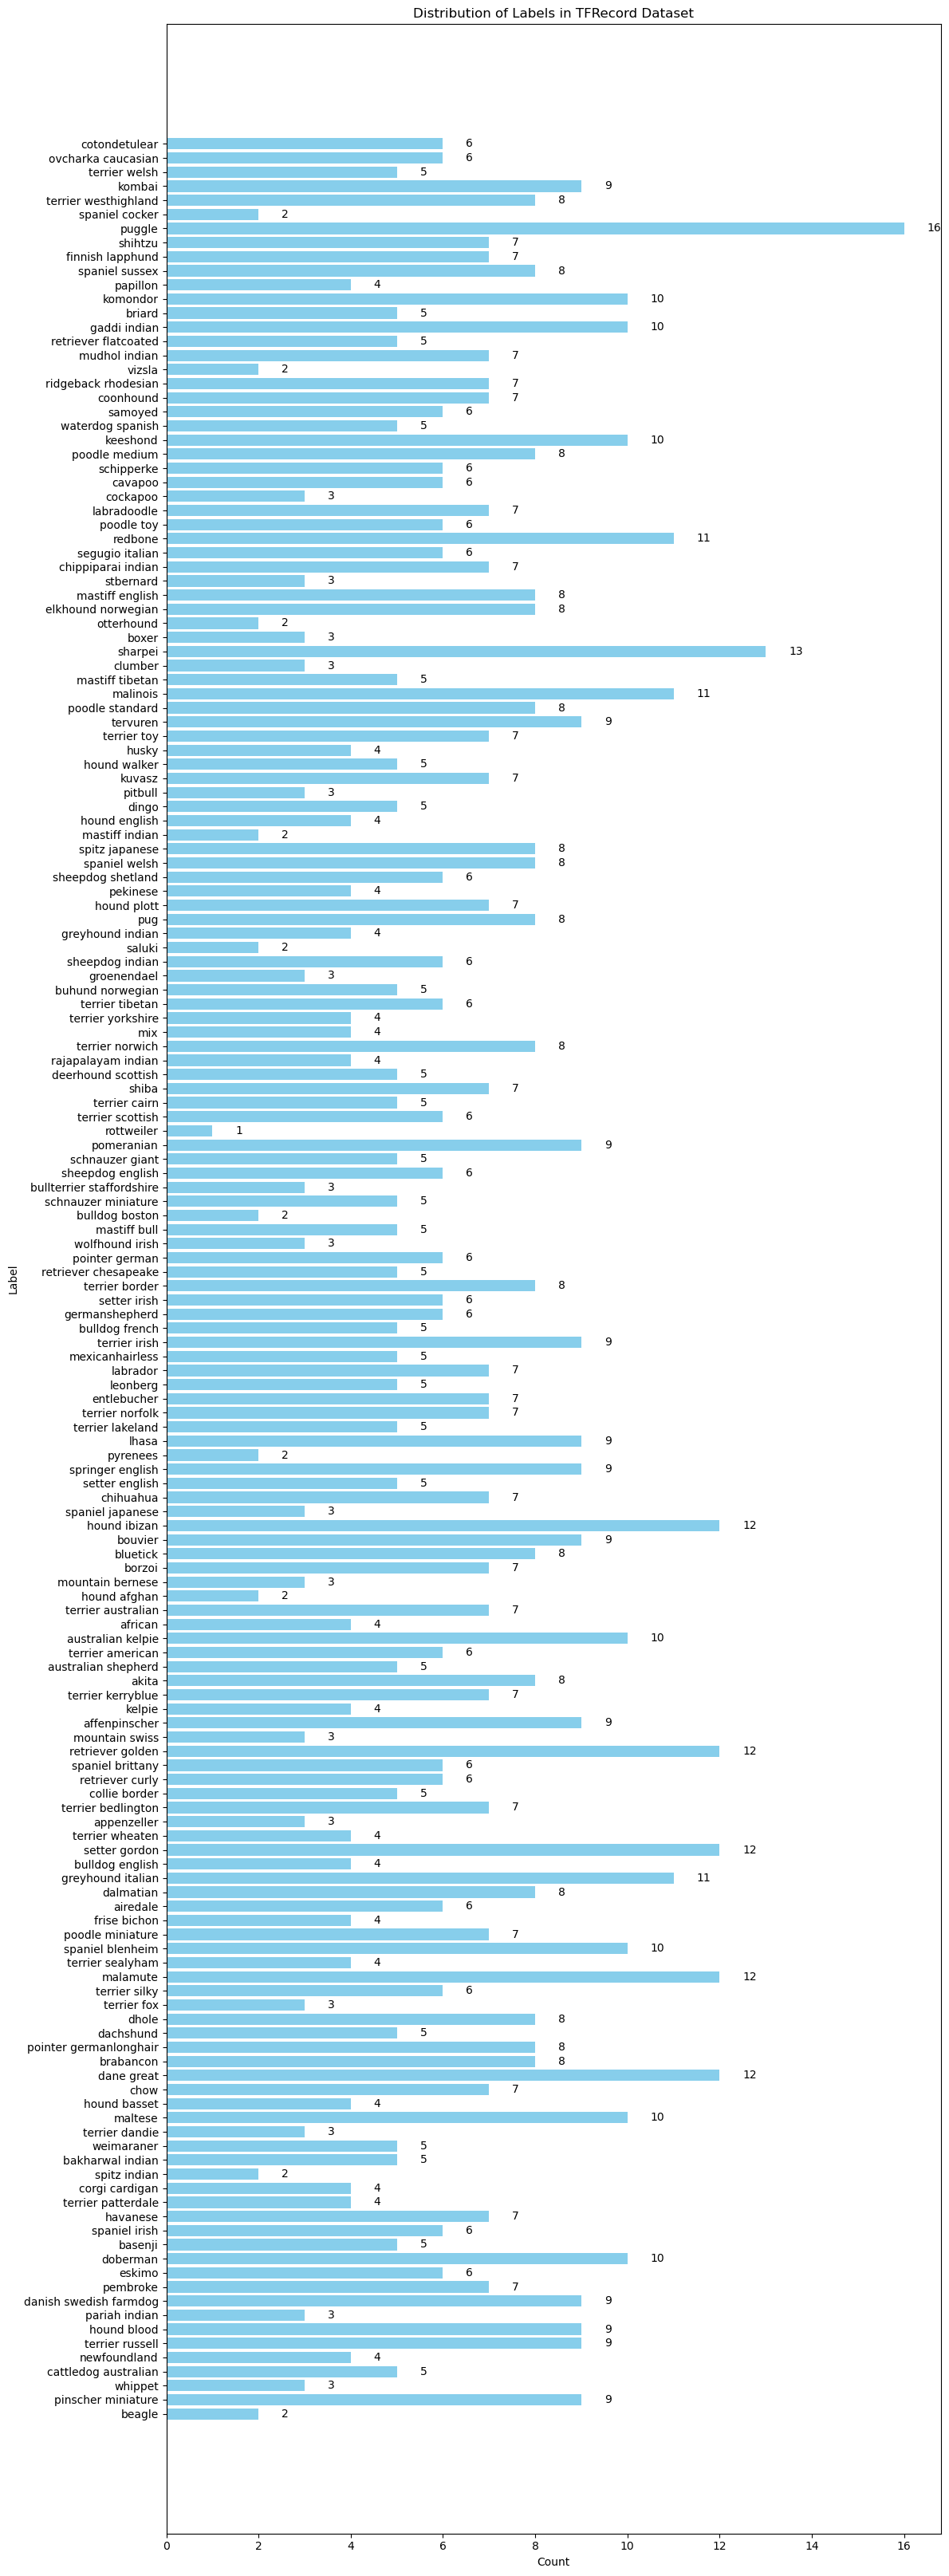

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from collections import Counter

# Get list of TFRecord files
tfrecord_files = tf.io.gfile.glob('gs://creature-vision-training-set/processed/v-20250315/*.tfrecord')
print(f"Found {len(tfrecord_files)} TFRecord files")

# Load the label map from GCS
with tf.io.gfile.GFile('gs://creature-vision-training-set/processed/metadata/label_map.json', 'r') as f:
    label_map = json.load(f)

# Create an inverse mapping from ID to label name
id_to_label = {v: k for k, v in label_map.items()}

def decode_example(example):
    # Define the features based on your updated pipeline code
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }
    
    # Parse the example
    parsed_features = tf.io.parse_single_example(example, feature_description)
    
    # Return both label and filename for analysis
    return parsed_features['label'], parsed_features['filename']

# Create dataset that extracts labels and filenames
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(lambda x: decode_example(x))

# Collect all labels and filenames
all_labels = []
all_filenames = []
for label, filename in dataset:
    all_labels.append(int(label.numpy()))
    all_filenames.append(filename.numpy().decode('utf-8'))

# Count label occurrences
label_counts = Counter(all_labels)

# Convert counts to lists for visualization
labels = []
counts = []
for label_id, count in sorted(label_counts.items()):
    label_name = id_to_label.get(label_id, f"Unknown ID: {label_id}")
    labels.append(label_name)
    counts.append(count)

# Calculate percentages (for logging purposes)
total_samples = sum(counts)
percentages = [count / total_samples * 100 for count in counts]

# Print statistics
print(f"Total samples: {total_samples}")
print("Label distribution:")
for label, count, percentage in zip(labels, counts, percentages):
    print(f"  {label}: {count} samples ({percentage:.2f}%)")

# Analyze filename distribution
filename_counts = Counter(all_filenames)
duplicate_files = {filename: count for filename, count in filename_counts.items() if count > 1}

print("\nFilename distribution:")
print(f"  Unique filenames: {len(filename_counts)}")
print(f"  Total files: {len(all_filenames)}")
print(f"  Duplicate files: {len(duplicate_files)}")

if duplicate_files:
    print("\nDuplicate files found:")
    for filename, count in sorted(duplicate_files.items(), key=lambda x: x[1], reverse=True):
        print(f"  {filename}: {count} occurrences")

# Adjust figure height based on number of groups
plt.figure(figsize=(12, max(6, len(labels) * 0.2)))
bars = plt.barh(labels, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Distribution of Labels in TFRecord Dataset')
plt.tight_layout()

# Add count labels on the bars
for bar, count in zip(bars, counts):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        str(count),
        ha='left',
        va='center'
    )
plt.show()

# Function to visualize a few examples with their labels and filenames
def visualize_examples(num_examples=5):
    full_dataset = tf.data.TFRecordDataset(tfrecord_files)
    full_dataset = full_dataset.map(decode_full_example)
    
    for i, (image, label, filename) in enumerate(full_dataset.take(num_examples)):
        label_id = label.numpy()
        label_name = id_to_label.get(int(label_id), f"Unknown label ID: {label_id}")
        filename_str = filename.numpy().decode('utf-8')
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image.numpy())
        plt.title(f"Label: {label_name} (ID: {label_id})\nFilename: {filename_str}")
        plt.show()

def decode_full_example(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.io.parse_single_example(example, feature_description)
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.uint8)
    return image, parsed_features['label'], parsed_features['filename']

# Uncomment to visualize examples
# visualize_examples(5)
